In [4]:
import pandas as pd
import geocoder
from sklearn.metrics import classification_report
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [2]:
geo_df = pd.read_csv('./delivery_geography.csv')
price_df = pd.read_csv('./delivery_prices.csv')

In [3]:
geo_df.head()

,orderid,latitude,longitude,estimateddeliverytime
0,1552679,37.697073,-122.485903,259.0
1,1552697,37.782185,-122.454544,54.0
2,1552675,37.780840,-122.395820,228.0
3,1552934,37.783131,-122.388962,209.0
4,1552983,37.323786,-121.878904,345.0


In [5]:
price_df.head()

,orderid,deliveredat,totalprice
0,1552553,2017-08-08T00:02:29.980+00:00,176.11
1,1552559,2017-08-08T00:09:06.077+00:00,71.03
2,1552499,2017-08-08T00:15:03.847+00:00,61.95
3,1552617,2017-08-08T00:16:40.820+00:00,62.40
4,1552632,2017-08-08T00:31:27.957+00:00,64.16


In [6]:
price_df.dtypes #delivery dates will need to be converted to datetimes

orderid          int64
deliveredat     object
totalprice     float64
dtype: object

## 1. Join the dataframes

In [7]:
merge_df = pd.merge(price_df,geo_df, on='orderid', how='inner') #join on the orderids

In [8]:
merge_df.head()

,orderid,deliveredat,totalprice,latitude,longitude,estimateddeliverytime
0,1552617,2017-08-08T00:16:40.820+00:00,62.40,37.771846,-122.434059,122.0
1,1552632,2017-08-08T00:31:27.957+00:00,64.16,37.383711,-122.075689,195.0
2,1552749,2017-08-08T00:31:53.977+00:00,96.40,37.677605,-122.101465,138.0
3,1552758,2017-08-08T00:45:28.393+00:00,52.00,37.405777,-122.062815,123.0
4,1552814,2017-08-08T00:53:28.553+00:00,61.52,37.445134,-122.227978,167.0


In [9]:
print 'merge_df rows = %d, price_df rows = %d, geo_df rows = %d' %(merge_df.shape[0], price_df.shape[0], geo_df.shape[0])

merge_df rows = 3283, price_df rows = 3352, geo_df rows = 3780


In [10]:
#External data sources based on latitude/longitude and the deliverydates... 

In [11]:
merge_df2 = merge_df
merge_df2['deliveredat'] = pd.to_datetime(merge_df2['deliveredat'])
merge_df2['day_of_week'] = merge_df2['deliveredat'].dt.weekday_name

In [12]:
merge_df2.head()

,orderid,deliveredat,totalprice,latitude,longitude,estimateddeliverytime,day_of_week
0,1552617,2017-08-08 00:16:40.820,62.40,37.771846,-122.434059,122.0,Tuesday
1,1552632,2017-08-08 00:31:27.957,64.16,37.383711,-122.075689,195.0,Tuesday
2,1552749,2017-08-08 00:31:53.977,96.40,37.677605,-122.101465,138.0,Tuesday
3,1552758,2017-08-08 00:45:28.393,52.00,37.405777,-122.062815,123.0,Tuesday
4,1552814,2017-08-08 00:53:28.553,61.52,37.445134,-122.227978,167.0,Tuesday


In [13]:
merge_df2['hour'] = ''
merge_df2['minute'] = ''

## 2. Add in extra information based on the lat/lon columns

In [14]:
merge_df2['city'] = ''
merge_df2['county'] = ''
merge_df2['postal'] = ''

In [15]:
for index, row in merge_df2.iterrows():
  merge_df2.loc[index, 'hour'] = row['deliveredat'].hour
  merge_df2.loc[index, 'minute'] = row['deliveredat'].minute

In [16]:
#Going to find the City and county for each of the orders with Google API
for index, row in merge_df2.iterrows():
  lat = row['latitude'] 
  lon = row['longitude']
  try:
    #result = Geocoder.reverse_geocode(lat, lon)
    result = geocoder.bing([lat,lon], method='reverse')
    merge_df2.loc[index, 'city'] = result.city
    merge_df2.loc[index, 'county'] = result.raw['address']['adminDistrict2']
    merge_df2.loc[index, 'postal'] = result.raw['address']['postalCode']
  except: 
    continue


In [18]:
lb = LabelEncoder()
merge_df2['dow_encode'] = lb.fit_transform(merge_df2['day_of_week'])
merge_df2['county_encode'] = lb.fit_transform(merge_df2['county'])
merge_df2['city_encode'] = lb.fit_transform(merge_df2['city'])

In [19]:
merge_df2.to_csv('./eaze_checkpoint1.csv')

In [188]:
merge_df2 = pd.read_csv('./eaze_checkpoint1.csv')

In [21]:
merge_df2['deliveredat'] = pd.to_datetime(merge_df2['deliveredat'])
merge_df2['deliveredat'].describe()
#all the same delivery date so we can't really account for seasonality in this
#it would be very beneficial to have a user table to do feature engineering on time delay between deliveries 

count                           3283
unique                          3280
top       2017-08-08 04:59:33.207000
freq                               2
first     2017-08-08 00:06:36.547000
last      2017-08-08 23:59:55.787000
Name: deliveredat, dtype: object

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

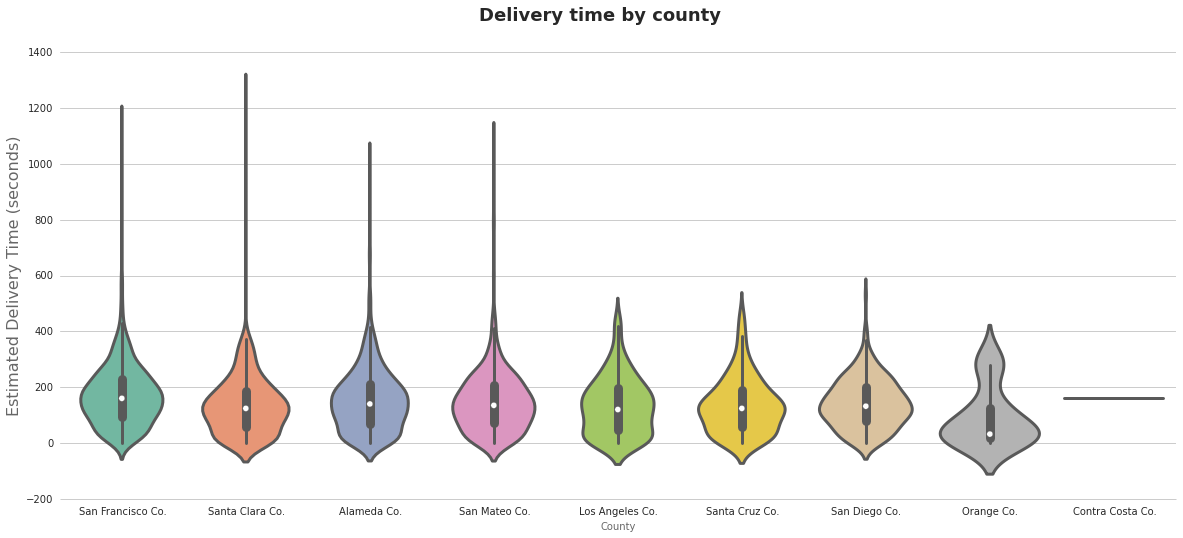

In [23]:
#get a feel for the distribution of the delivery time and prices across different countys
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(20, 8))
sns.violinplot(x="county",y="estimateddeliverytime",data=merge_df2, inner="box", palette="Set2", cut=2, linewidth=3)
sns.despine(left=True)

f.suptitle('Delivery time by county', fontsize=18, fontweight='bold')
ax.set_xlabel("County",size = 10,alpha=0.7)
ax.set_ylabel("Estimated Delivery Time (seconds)",size = 16,alpha=0.7)

In [ ]:
#We can see much more variance in the delivery time for bay area deliveries. I did not expect that!

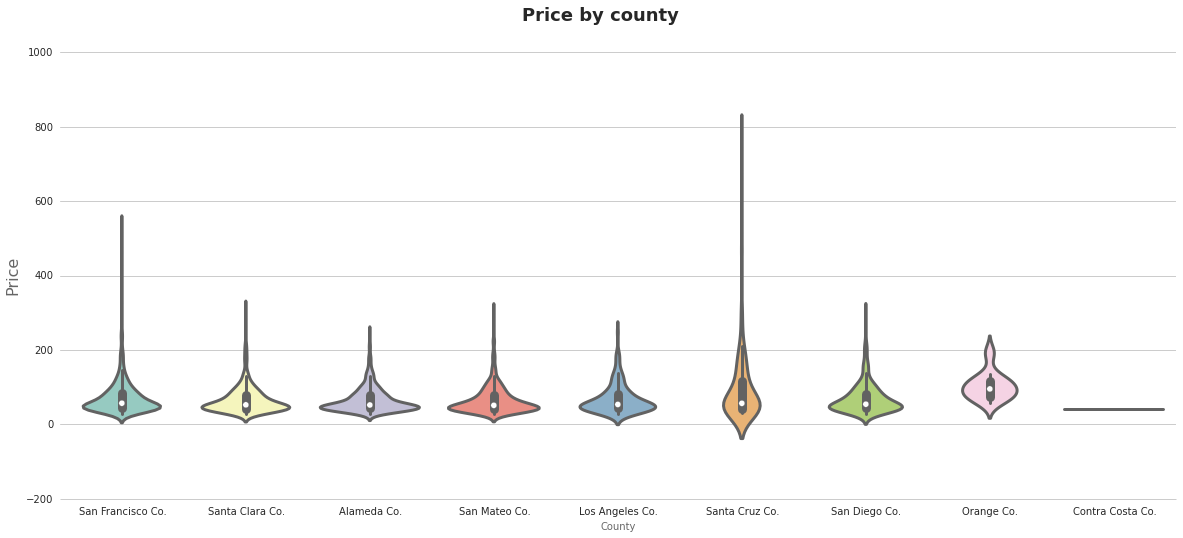

In [24]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(20, 8))
sns.violinplot(x="county",y="totalprice",data=merge_df2, inner="box", palette="Set3", cut=2, linewidth=3)
sns.despine(left=True)

f.suptitle('Price by county', fontsize=18, fontweight='bold')
ax.set_xlabel("County",size = 10,alpha=0.7)
ax.set_ylabel("Price",size = 16,alpha=0.7)

In [ ]:
#Orders have a significantly larger average price in Orange County. What about the stock here is different?
#Is weed just more expensive in the OC? 

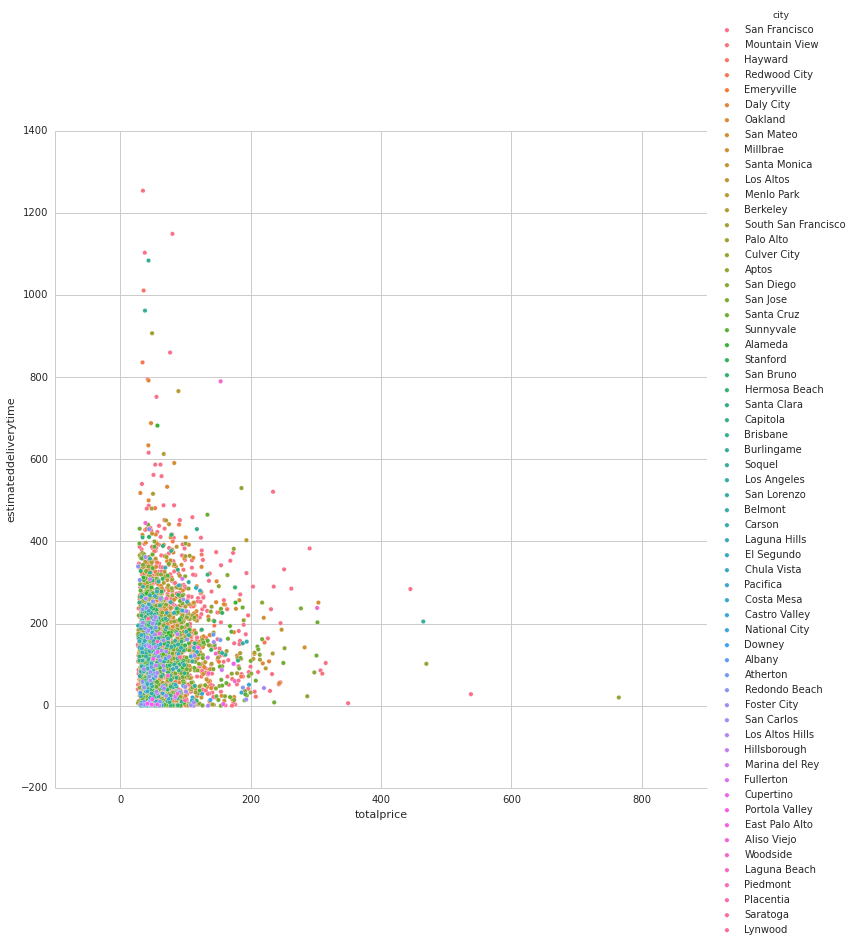

In [25]:
#Does delivery time vary with city?
sns.pairplot(x_vars=["totalprice"], y_vars=["estimateddeliverytime"], data=merge_df2, hue="city", size=10)

In [27]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
X = merge_df2[['totalprice', 'estimateddeliverytime', 'hour', 'minute']]

In [28]:
#Figure out a starting number of clusters to run the model with
distortions = []
K = range(3,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

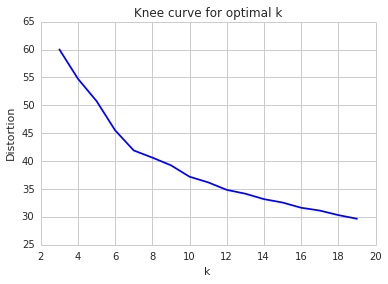

In [29]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Knee curve for optimal k')
plt.show()

In [30]:
#we can see that 12 is a reasonable tradeoff where the improvements might not warrant increased complexity
kmeans = KMeans(n_clusters=12).fit(X)

In [31]:
kmeans.cluster_centers_

array([[  50.27987322,  172.10776545,    7.57527734,   30.33755943],
       [  69.98454545,  479.76363636,    7.54545455,   29.27272727],
       [ 110.75829596,   41.1838565 ,   10.14349776,   29.84304933],
       [  58.35928571,  932.92857143,    8.28571429,   28.07142857],
       [ 206.97060241,   86.51807229,   10.07228916,   32.04819277],
       [ 104.65100694,  140.39583333,    8.97222222,   29.44444444],
       [  62.43327935,  330.72469636,    8.0242915 ,   30.78947368],
       [  51.32058462,  101.27076923,    6.97076923,   28.74923077],
       [  50.99387833,   23.44106464,    7.47148289,   28.92585551],
       [ 536.338     ,  127.8       ,    8.6       ,   31.6       ],
       [ 174.73439394,  245.33333333,    9.68181818,   29.81818182],
       [  59.05658586,  238.94141414,    8.32929293,   29.54343434]])

In [32]:
Y = kmeans.predict(X)

In [34]:
merge_df2['cluster'] = Y

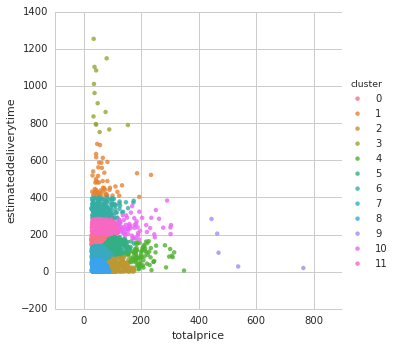

In [35]:
sns.lmplot('totalprice', 'estimateddeliverytime', data=merge_df2, hue='cluster', fit_reg=False)

In [36]:
#it seems that clusters 3 and 9 have a pretty high variance in `estimateddeliverytime` compared to the others
merge_df2.groupby('cluster')['estimateddeliverytime'].describe()['std']

cluster
0      19.114636
1      74.544534
2      26.706738
3     162.613494
4      40.792563
5      23.993094
6      31.979877
7      20.245426
8      20.081438
9     114.678682
10     42.796957
11     21.528500
Name: std, dtype: float64

In [37]:
probe_df = merge_df2[merge_df2['cluster'].isin([3,9])]

In [38]:
probe_df

,orderid,deliveredat,totalprice,latitude,longitude,estimateddeliverytime,day_of_week,hour,minute,city,county,postal,dow_encode,county_encode,city_encode,cluster
22,1553808,2017-08-08 02:59:06.147,89.40,37.441869,-122.193415,766.0,Tuesday,2,59,Menlo Park,San Mateo Co.,94025,0,6,34,3
86,1553102,2017-08-08 01:53:35.020,80.23,37.757154,-122.403130,1149.0,Tuesday,1,53,San Francisco,San Francisco Co.,94107,0,5,49,3
146,1552989,2017-08-08 01:12:46.703,464.76,36.984471,-121.963229,205.0,Tuesday,1,12,Soquel,Santa Cruz Co.,95073,0,8,57,9
189,1554829,2017-08-08 05:08:53.070,43.75,37.819650,-122.257170,792.0,Tuesday,5,8,Oakland,Alameda Co.,94611,0,0,38,3
231,1552674,2017-08-08 00:31:12.197,445.02,37.793949,-122.398062,284.0,Tuesday,0,31,San Francisco,San Francisco Co.,94111,0,5,49,9
305,1555500,2017-08-08 19:53:44.163,764.56,36.981861,-121.910776,20.0,Tuesday,19,53,Aptos,Santa Cruz Co.,95003,0,8,4,9
560,1555499,2017-08-08 19:25:27.437,42.42,37.772434,-122.502704,795.0,Tuesday,19,25,San Francisco,San Francisco Co.,94121,0,5,49,3
887,1556095,2017-08-08 23:15:52.213,34.51,37.484642,-122.196348,836.0,Tuesday,23,15,Redwood City,San Mateo Co.,94063,0,6,45,3
910,1553094,2017-08-08 02:04:01.710,49.04,37.395126,-122.166913,907.0,Tuesday,2,4,Palo Alto,Santa Clara Co.,94304,0,7,40,3
940,1554570,2017-08-08 04:53:31.253,35.07,37.392203,-122.060990,1254.0,Tuesday,4,53,Mountain View,Santa Clara Co.,94043,0,7,36,3


In [39]:
#Cluster 3 is small orders with massive delivery times
#Cluster 9 is huge orders with substantial delivery times
#The main issue is with cluster 3. Taking a long time to fulfill these orders shows a serious flaw in dispatch
merge_df2.to_csv('./annotated.csv')